In [2]:
from google.colab import files, drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [12]:
!ln -s gdrive/My\ Drive/donkey donkey
!ls -l donkey/

ln: failed to create symbolic link 'donkey/donkey': Function not implemented
total 65291
-rw------- 1 root root 15873326 Oct 16 11:20 record1.zip
-rw------- 1 root root 26694617 Oct 16 11:21 record2.zip
-rw------- 1 root root 24289082 Oct 16 11:21 record3.zip


In [0]:
# Importy Pythonowe

import json
import os
import zipfile
import glob

import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

from tqdm import tqdm

import seaborn as sns
sns.set_style('whitegrid')

import keras as K
import keras.layers as KL

import IPython.display
from IPython.display import HTML

In [21]:
# Czytanie danych do pamięci
records = []
for archive_f in ['donkey/record2.zip', 'donkey/record3.zip']:
  with zipfile.ZipFile(archive_f) as archive:
    for fileinfo in tqdm(archive.filelist):
      filename = fileinfo.filename
      if not filename.endswith('.json') or filename.endswith('meta.json'):
        continue
      with archive.open(filename) as f:
        data = json.load(f)
      basename = os.path.basename(filename)
      dirname = os.path.dirname(filename)
      # ucinamy 'record_' z przodu i '.json' z tylu
      step_number = int(basename[7:-5])
      with archive.open(
          os.path.join(dirname, data['image_array'])) as image_file:
        image = ndimage.imread(image_file) / 255.0
      records.append((step_number, image, data['user_angle'], data['user_throttle']))
records.sort(key=lambda x: x[0])
images = np.array([r[1] for r in records], dtype='float32')
angles = np.array([r[2] for r in records], dtype='float32')[:, None]
throttles = np.array([r[3] for r in records], dtype='float32')[:, None]




Exception ignored in: <bound method tqdm.__del__ of   2%|▏         | 282/15234 [00:16<15:20, 16.24it/s]>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/usr/lib/python3.6/threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread
100%|██████████| 14178/14178 [01:07<00:00, 210.10it/s] 


In [0]:
images = images[:,72:,:,:]

In [29]:
print('Images to tablica o wymiarach:', images.shape)
print('Angles to tablica o wymiarach:', angles.shape)
print('Throttles to tablica o wymiarach:', throttles.shape)

# Dane (images, angles) podzielimy na 3 podzbiory:
# - dane uczące (train_images, train_angles), na których będziemy trenować modele
# - dane walidacyjne (valid_images, valid_angles) również użyte do treningu modeli
# - dane testowe (test_images, test_angles) na których ocenimy jak dobrze działa
#   nasz model
train_images, valid_images, test_images = np.split(images, [-1000, -500])
train_angles, valid_angles, test_angles = np.split(angles, [-1000, -500])
(train_throttles, valid_throttles, test_throttles
    ) = np.split(throttles, [-1000, -500])

print('Dane uczące mają %d klatek, walidacyjne %d i testowe %d.' % 
      (train_images.shape[0], valid_images.shape[0], test_images.shape[0]))

Images to tablica o wymiarach: (14704, 48, 160, 3)
Angles to tablica o wymiarach: (14704, 1)
Throttles to tablica o wymiarach: (14704, 1)
Dane uczące mają 13704 klatek, walidacyjne 500 i testowe 500.


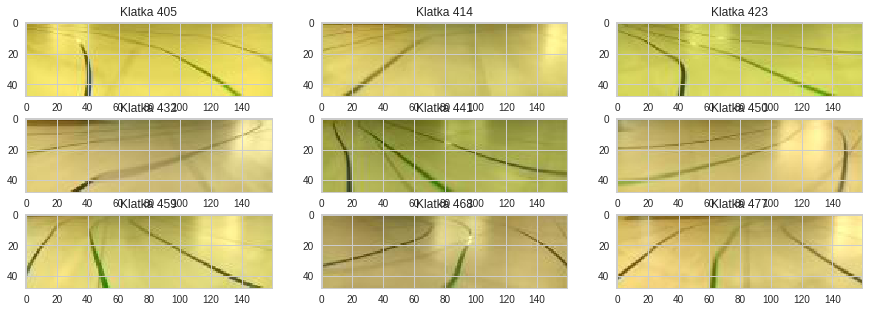

In [30]:
# Wizualizacja danych

k = 5
plt.figure(figsize=(15, 5))
for i, frame in enumerate(range(k*9*9, (k+1)*9*9, 9)):
  plt.subplot(3, 3, i + 1)
  plt.imshow(images[frame])
  plt.title("Klatka %d" % (frame,))

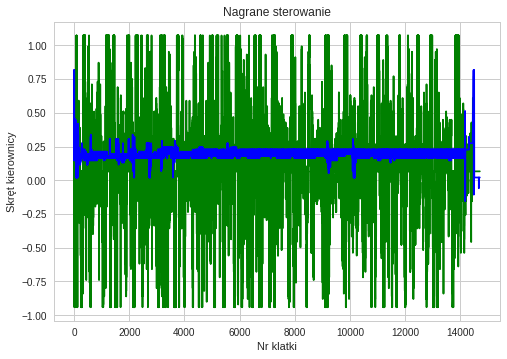

In [31]:
plt.plot(angles, color='g', label='recorded steering')
plt.plot(throttles, color='b', label='recorded steering')
plt.title('Nagrane sterowanie')
plt.xlabel('Nr klatki')
plt.ylabel('Skręt kierownicy')
None

In [0]:
  img_in = KL.Input(shape=(6, 48, 160, 3), name='img_in')
  x = img_in
  x = KL.BatchNormalization()(x)

  x = KL.Convolution3D(filters=24, kernel_size=(1, 5, 5), padding='same', activation='relu')(x)
  x = KL.Convolution3D(filters=32, kernel_size=(1, 5, 5), padding='same', activation='relu')(x)
  x = KL.MaxPooling3D(pool_size=(1, 1, 2))(x)
  x = KL.BatchNormalization()(x)
  x = KL.Convolution3D(filters=64, kernel_size=(2, 5, 5), activation='relu')(x)
  x = KL.Convolution3D(filters=64, kernel_size=(2, 3, 3), activation='relu')(x)
  x = KL.MaxPooling3D(pool_size=(1, 2, 2))(x)
  x = KL.BatchNormalization()(x)
  x = KL.Convolution3D(filters=64, kernel_size=(2, 3, 3), activation='relu')(x)
  x = KL.Convolution3D(filters=32, kernel_size=(2, 3, 3), activation='relu')(x)
  x = KL.MaxPooling3D(pool_size=(1, 2, 2))(x)
  x = KL.BatchNormalization()(x)

  x = KL.Flatten(name='flattened')(x)
  x = KL.Dense(units=64, activation='linear')(x)
  x = KL.BatchNormalization()(x)
  # categorical output of the angle
  angle_out = KL.Dense(units=1, activation='linear', name='angle_out')(x)

  # continous output of throttle
  throttle_out = KL.Dense(units=1, activation='linear', name='throttle_out')(x)

  model = K.Model(inputs=[img_in], outputs=[angle_out, throttle_out])

  model.compile(optimizer='adam',
                loss={'angle_out': 'mean_squared_error',
                      'throttle_out': 'mean_squared_error'},
                loss_weights={'angle_out': 0.5, 'throttle_out': 0.5})


In [0]:
def data_generator(X, Y, batch_size, shuffle=True):
  A, T = Y
  back_ind = np.array([1, 2, 4, 8, 16, 32]).reshape(1, -1)
  while True:
    n = X.shape[0]
    indices = np.arange(n)
    if shuffle:
      np.random.shuffle(indices)
    for i in range(0, n, batch_size):
      batch_ind = indices[i:i+batch_size]
      batch_back_ind = np.maximum(0, batch_ind.reshape(-1, 1) - back_ind)
      yield (X[batch_back_ind], [A[batch_ind], T[batch_ind]])

In [64]:
callbacks = [
    K.callbacks.ModelCheckpoint('model', save_best_only=True),
    K.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=.0005,
                              patience=5,
                              verbose=True,
                              mode='auto')
]

batch_size=16
# Model uczymy na danych uczących.
# Po każdej epoce (ang. epoch) policzymy błąd na danych walidacyjnych i jeśli
# model jest lepszy (błąd jest mniejszy), zapisujemy go.

hist = model.fit_generator(data_generator(train_images, (train_angles, train_throttles), batch_size),
                 steps_per_epoch=len(train_images)/batch_size,
                 epochs=200, 
                 validation_data=data_generator(valid_images, (valid_angles, valid_throttles), batch_size),
                 validation_steps=len(valid_images)/batch_size,
                 callbacks=callbacks)


857/856 [==============================] - 497s 580ms/step - loss: 0.0295 - angle_out_loss: 0.0572 - throttle_out_loss: 0.0019 - val_loss: 0.0354 - val_angle_out_loss: 0.0661 - val_throttle_out_loss: 0.0047
Epoch 9/200
857/856 [==============================] - 497s 580ms/step - loss: 0.0282 - angle_out_loss: 0.0546 - throttle_out_loss: 0.0018 - val_loss: 0.0316 - val_angle_out_loss: 0.0606 - val_throttle_out_loss: 0.0027
Epoch 10/200
857/856 [==============================] - 498s 581ms/step - loss: 0.0273 - angle_out_loss: 0.0528 - throttle_out_loss: 0.0018 - val_loss: 0.0385 - val_angle_out_loss: 0.0722 - val_throttle_out_loss: 0.0048
Epoch 11/200
857/856 [==============================] - 499s 582ms/step - loss: 0.0260 - angle_out_loss: 0.0502 - throttle_out_loss: 0.0018 - val_loss: 0.0318 - val_angle_out_loss: 0.0616 - val_throttle_out_loss: 0.0020
Epoch 00011: early stopping


## Analiza wyuczonej sieci
Najpierw sprawdzimy błąd MSE osiągnięty przez sieć.

In [69]:
#@title Wczytywanie najlepszej sieci
best_model = K.models.load_model('model')

print('Obliczony przez Keras błąd walidacyjny:',
      best_model.evaluate_generator(data_generator(valid_images,
         (valid_angles, valid_throttles), batch_size),
         steps=len(valid_images)/batch_size, verbose=0))
print('Obliczony przez Keras błąd testowy:',
      best_model.evaluate_generator(data_generator(test_images,
         (test_angles, test_throttles), batch_size),
         steps=len(test_images)/batch_size, verbose=0))

Obliczony przez Keras błąd walidacyjny: [0.029743149161338807, 0.05701637548208237, 0.0024699230063706637]
Obliczony przez Keras błąd testowy: [0.029780339386314154, 0.023367713801562787, 0.03619296485185623]


Teraz zobaczymy jak można wykorzystać sieć do przewidywania sterowania na danych testowych:

In [0]:
#@title Użycie najlepszej sieci

# Obliczamy kąty przewidziane przez sieć na danych testowych
pred_test_angles, pred_test_throttles = best_model.predict_generator(data_generator(test_images,
         (test_angles, test_throttles), 1, shuffle=False), steps=len(test_images))

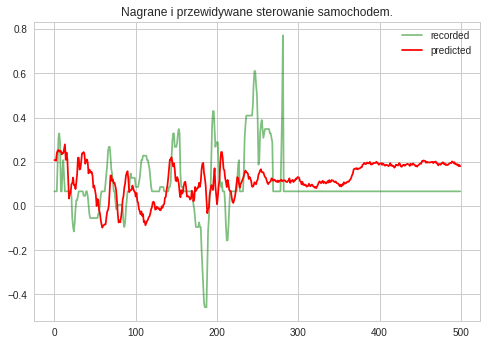

In [72]:
plt.plot(test_angles, label='recorded', color='g', alpha=0.5)
plt.plot(pred_test_angles, label='predicted', color='r')
plt.legend(loc='upper right')
plt.title('Nagrane i przewidywane sterowanie samochodem.')
None

In [0]:
files.download('model')